In [28]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

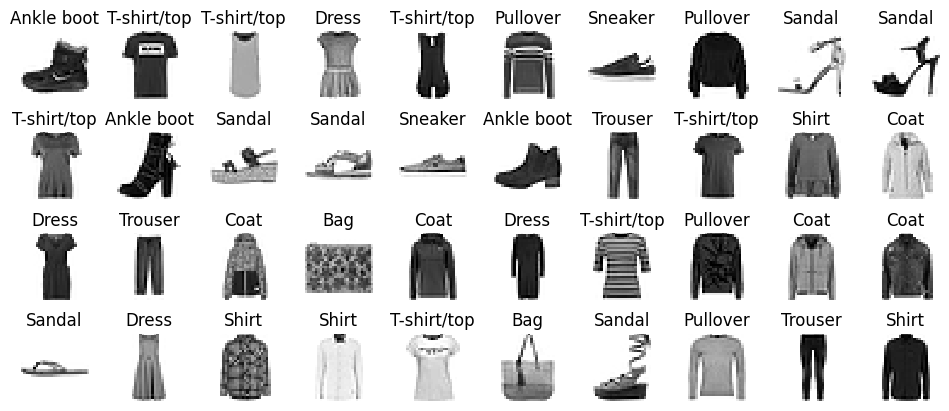

In [4]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Split dataset
We creae two dataset from we loaded above. The first dataset with 08 classes and second with 02 classes.

In [8]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

In [45]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

X_train_B = X_train_B[:50]
y_train_B = y_train_B[:50]

In [46]:
print("Dataset shape for model A")
print("----------------------------------")
print("Training:", X_train_A.shape, y_train_A.shape)
print("Validation:", X_valid_A.shape, y_valid_A.shape)
print("Testing:", X_test_B.shape, y_test_A.shape)

Dataset shape for model A
----------------------------------
Training: (44011, 28, 28) (44011,)
Validation: (3989, 28, 28) (3989,)
Testing: (2000, 28, 28) (8000,)


In [47]:
print("Dataset shape for model B")
print("----------------------------------")
print("Training:", X_train_B.shape, y_train_B.shape)
print("Validation:", X_valid_B.shape, y_valid_B.shape)
print("Testing:", X_test_B.shape, y_test_B.shape)

Dataset shape for model B
----------------------------------
Training: (50, 28, 28) (50,)
Validation: (1011, 28, 28) (1011,)
Testing: (2000, 28, 28) (2000,)


## Train and Save model A

In [29]:
tf.random.set_seed(42)

model_A = keras.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  
  keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  
  keras.layers.Dense(8, activation="softmax")
])

model_A.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=keras.optimizers.SGD(learning_rate=0.001),
  metrics=["accuracy"]
)

model_A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 8)                 808       
                                                                 
Total params: 99,508
Trainable params: 99,508
Non-trainable params: 0
_________________________________________________________________


In [30]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("../models/tf_model_A.keras", save_best_only=True)

history_A = model_A.fit(X_train_A, y_train_A, epochs=100,
                       validation_data=(X_valid_A, y_valid_A),
                       callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/100
1376/1376 [==============================] - 7s 3ms/step - loss: 1.1404 - accuracy: 0.6420 - val_loss: 0.7109 - val_accuracy: 0.7726
Epoch 2/100
1376/1376 [==============================] - 5s 3ms/step - loss: 0.6092 - accuracy: 0.8038 - val_loss: 0.5234 - val_accuracy: 0.8303
Epoch 3/100
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4880 - accuracy: 0.8443 - val_loss: 0.4490 - val_accuracy: 0.8488
Epoch 4/100
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4287 - accuracy: 0.8606 - val_loss: 0.4062 - val_accuracy: 0.8616
Epoch 5/100
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3919 - accuracy: 0.8715 - val_loss: 0.3779 - val_accuracy: 0.8681
Epoch 6/100
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3662 - accuracy: 0.8774 - val_loss: 0.3588 - val_accuracy: 0.8742
Epoch 7/100
1376/1376 [==============================] - 6s 4ms/step - loss: 0.3475 - accuracy: 0.8829 - val_loss: 0.3435 - val_ac

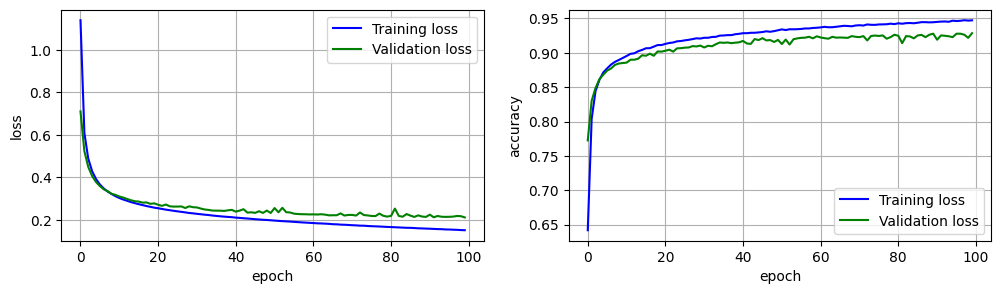

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 3))

plt.sca(axes[0])
plt.plot(history_A.epoch, history_A.history["loss"], "b", label="Training loss")
plt.plot(history_A.epoch, history_A.history["val_loss"], "g", label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

plt.sca(axes[1])
plt.plot(history_A.epoch, history_A.history["accuracy"], "b", label="Training loss")
plt.plot(history_A.epoch, history_A.history["val_accuracy"], "g", label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
plt.legend()

In [35]:
model_A.evaluate(X_test_A, y_test_A)

250/250 [==============================] - 1s 2ms/step - loss: 0.2181 - accuracy: 0.9254


[0.2181120365858078, 0.9253749847412109]

In [36]:
model_A = keras.models.load_model("../models/tf_model_A.keras")
model_A.evaluate(X_test_A, y_test_A)

250/250 [==============================] - 1s 2ms/step - loss: 0.2181 - accuracy: 0.9254


[0.2181120365858078, 0.9253749847412109]

## Train and Evaluate Model B from scrath

In [48]:
tf.random.set_seed(42)

model_B = keras.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  
  keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
  
  keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(
  loss="binary_crossentropy",
  optimizer=keras.optimizers.SGD(learning_rate=0.001),
  metrics=["accuracy"]
)

model_B.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               78500     
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 100)               10100     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


In [50]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("../models/tf_model_B.keras", save_best_only=True)

history_B = model_B.fit(X_train_B, y_train_B, epochs=100,
                       validation_data=(X_valid_B, y_valid_B),
                       callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/100
2/2 [==============================] - 1s 345ms/step - loss: 0.7315 - accuracy: 0.4400 - val_loss: 0.7019 - val_accuracy: 0.4936
Epoch 2/100
2/2 [==============================] - 0s 198ms/step - loss: 0.7224 - accuracy: 0.4400 - val_loss: 0.6959 - val_accuracy: 0.4975
Epoch 3/100
2/2 [==============================] - 0s 142ms/step - loss: 0.7138 - accuracy: 0.4800 - val_loss: 0.6896 - val_accuracy: 0.5025
Epoch 4/100
2/2 [==============================] - 0s 124ms/step - loss: 0.7048 - accuracy: 0.5000 - val_loss: 0.6838 - val_accuracy: 0.5213
Epoch 5/100
2/2 [==============================] - 0s 145ms/step - loss: 0.6968 - accuracy: 0.4800 - val_loss: 0.6785 - val_accuracy: 0.5321
Epoch 6/100
2/2 [==============================] - 0s 154ms/step - loss: 0.6885 - accuracy: 0.5200 - val_loss: 0.6731 - val_accuracy: 0.5579
Epoch 7/100
2/2 [==============================] - 0s 142ms/step - loss: 0.6807 - accuracy: 0.5600 - val_loss: 0.6681 - val_accuracy: 0.5786
Epoch 8/100
2

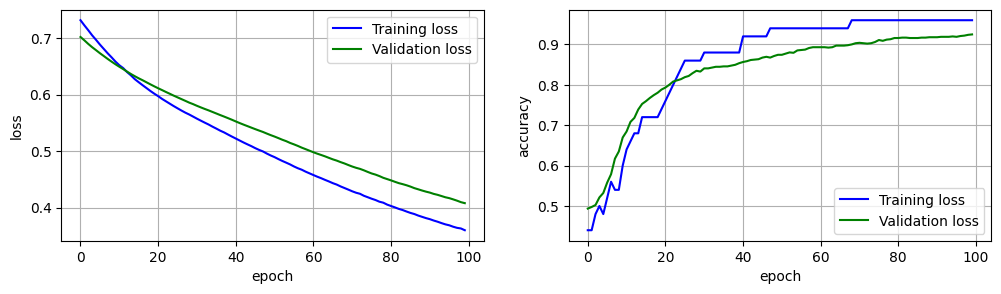

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 3))

plt.sca(axes[0])
plt.plot(history_B.epoch, history_B.history["loss"], "b", label="Training loss")
plt.plot(history_B.epoch, history_B.history["val_loss"], "g", label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

plt.sca(axes[1])
plt.plot(history_B.epoch, history_B.history["accuracy"], "b", label="Training loss")
plt.plot(history_B.epoch, history_B.history["val_accuracy"], "g", label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
plt.legend()

In [52]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.4119 - accuracy: 0.9100


[0.41193369030952454, 0.9100000262260437]

## Train model B from saved model A 

In [53]:
model_A = keras.models.load_model("../models/tf_model_A.keras")
model_A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 8)                 808       
                                                                 
Total params: 99,508
Trainable params: 99,508
Non-trainable params: 0
_________________________________________________________________


In [54]:
tf.random.set_seed(42)

clone_model_A = keras.models.clone_model(model_A)
clone_model_A.set_weights(model_A.get_weights())
clone_model_A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 8)                 808       
                                                                 
Total params: 99,508
Trainable params: 99,508
Non-trainable params: 0
_________________________________________________________________


First freeze the reused layers and train it during the first few epochs before unfreeze and train it

In [55]:
model_BA = keras.Sequential(clone_model_A.layers[:-1])
model_BA.add(keras.layers.Dense(1, activation="sigmoid"))

for layer in model_BA.layers[:-1]:
  layer.trainable = False

model_BA.compile(
  loss="binary_crossentropy",
  optimizer=keras.optimizers.SGD(learning_rate=0.001),
  metrics=["accuracy"]
)

model_BA.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 98,801
Trainable params: 101
Non-trainable params: 98,700
_________________________________________________________________


In [56]:
history_BA = model_BA.fit(X_train_B, y_train_B, epochs=5,
                         validation_data=(X_valid_B, y_valid_B))

Epoch 1/5
2/2 [==============================] - 1s 292ms/step - loss: 1.7256 - accuracy: 0.5200 - val_loss: 1.7258 - val_accuracy: 0.4995
Epoch 2/5
2/2 [==============================] - 0s 86ms/step - loss: 1.5592 - accuracy: 0.5200 - val_loss: 1.5226 - val_accuracy: 0.4876
Epoch 3/5
2/2 [==============================] - 0s 86ms/step - loss: 1.4164 - accuracy: 0.4600 - val_loss: 1.3844 - val_accuracy: 0.4718
Epoch 4/5
2/2 [==============================] - 0s 94ms/step - loss: 1.3072 - accuracy: 0.4600 - val_loss: 1.2484 - val_accuracy: 0.4560
Epoch 5/5
2/2 [==============================] - 0s 99ms/step - loss: 1.2127 - accuracy: 0.4800 - val_loss: 1.1449 - val_accuracy: 0.4332


In [57]:
for layer in model_BA.layers[:-1]:
  layer.trainable = True

model_BA.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
  metrics=["accuracy"]
)

model_BA.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


In [58]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("../models/tf_model_BA.keras", save_best_only=True)

history_BA = model_BA.fit(X_train_B, y_train_B, epochs=100,
                       validation_data=(X_valid_B, y_valid_B),
                       callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/100
2/2 [==============================] - 1s 324ms/step - loss: 1.1358 - accuracy: 0.3800 - val_loss: 0.9770 - val_accuracy: 0.4125
Epoch 2/100
2/2 [==============================] - 0s 144ms/step - loss: 0.9885 - accuracy: 0.4000 - val_loss: 0.8606 - val_accuracy: 0.4362
Epoch 3/100
2/2 [==============================] - 0s 120ms/step - loss: 0.9080 - accuracy: 0.4600 - val_loss: 0.8213 - val_accuracy: 0.4787
Epoch 4/100
2/2 [==============================] - 0s 132ms/step - loss: 0.8378 - accuracy: 0.5600 - val_loss: 0.7556 - val_accuracy: 0.5361
Epoch 5/100
2/2 [==============================] - 0s 131ms/step - loss: 0.7833 - accuracy: 0.5600 - val_loss: 0.7065 - val_accuracy: 0.5865
Epoch 6/100
2/2 [==============================] - 0s 118ms/step - loss: 0.7312 - accuracy: 0.5800 - val_loss: 0.6786 - val_accuracy: 0.6142
Epoch 7/100
2/2 [==============================] - 0s 126ms/step - loss: 0.6899 - accuracy: 0.6200 - val_loss: 0.6401 - val_accuracy: 0.6588
Epoch 8/100
2

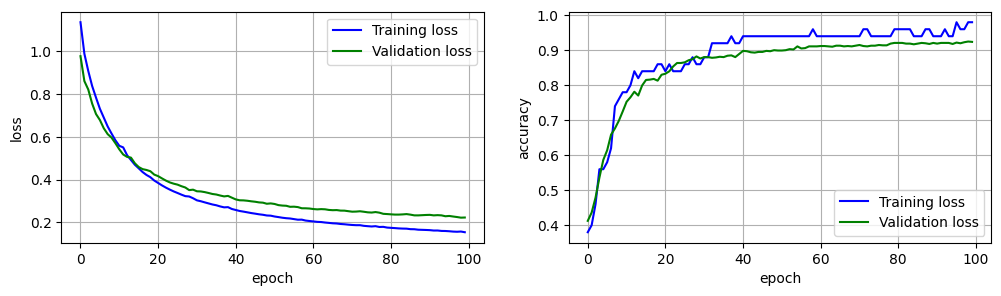

In [59]:
hfig, axes = plt.subplots(ncols=2, figsize=(12, 3))

plt.sca(axes[0])
plt.plot(history_BA.epoch, history_BA.history["loss"], "b", label="Training loss")
plt.plot(history_BA.epoch, history_BA.history["val_loss"], "g", label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

plt.sca(axes[1])
plt.plot(history_BA.epoch, history_BA.history["accuracy"], "b", label="Training loss")
plt.plot(history_BA.epoch, history_BA.history["val_accuracy"], "g", label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
plt.legend()

In [60]:
model_BA.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.2380 - accuracy: 0.9255


[0.23798054456710815, 0.9254999756813049]

# We can see that the model B trained from model A is more better than the model B trained from scratch